# Tugas Besar 2 - Agglomerative Clustering

- Ardysatrio Fakhri Haroen, 13517062
- Dandi Agus Maulana, 
- Ahmad Mutawalli,
- Harry Rahmadi Munly, 13517033

### Import Libraries

In [32]:
from sklearn.datasets import load_iris
import pandas as pd
import numpy as np
import math

### Load Data

In [33]:
iris_X, iris_y = load_iris(return_X_y=True)
iris_data = pd.DataFrame(iris_X, columns=['sepal_length', 'sepal_width', 'petal_length', 'petal_width'])
iris_data['label'] = pd.Series(iris_y)
iris_data_target = iris_data['label'].values.tolist()

### Wrapper Class for Algorithm

In [34]:
class AgglomerativeClustering () :
  # Wrapper class for Hierarchical Agglomerative Clustering
  # Designed for python list 

  def __init__ (self):    

    self.n_data = None
    self.n_features = None
    self.data = None
    self.cluster_distances = None
    self.cluster_list = None
    self.merged_clusters = None
    self.clusters_made = None

  # returns euclidian distance between two instances in float
  def calculate_distance_two_instance (self, instance1, instance2):

    if (len(instance1) == len(instance2)):

      sum_squares = 0 
      for i in range(self.n_features):
        sum_squares += ((instance1[i] - instance2[i]) ** 2)

      return sum_squares ** 0.5

    else:
      print("Length of instances not equal")

  # given a list of data-point indexes, returns feature average of given data points
  def calculate_feature_average (self, indexes):

    feature_average = []

    for feat_idx in range(self.n_features):
      
      feature_sum = 0
      for data_idx in indexes:
        feature_sum += self.data[data_idx][feat_idx]

      feature_average.append( float(feature_sum) / float(len(indexes)))
      
    return feature_average

  # calculate distance between all data points
  def calculate_cluster_distances (self):

    self.cluster_distances = [[0 for i in range(self.n_data)] for j in range(self.n_data)]

    for i in range(self.n_data):

      for j in range(i+1, self.n_data):

        self.cluster_distances[i][j] = self.calculate_distance_two_instance(self.data[i], self.data[j])
        self.cluster_distances[j][i] = self.cluster_distances[i][j]

  # initialize cluster list values
  def init_clusters (self):

    self.cluster_list = [[i] for i in range(self.n_data)]
  
  # initalize attribute values
  def init_attributes (self, data):

    self.data = data
    self.n_data = len(data)
    self.n_features = len(data[0])
    self.calculate_cluster_distances()
    self.init_clusters()
    self.merged_clusters = []
    self.clusters_made = self.n_data

  # find the closest clusters for subsequent merging
  def find_closest_clusters (self):

    min_i = -1
    min_j = -1
    min_dist = -1
    # iterate every cluster
    for i in range(len(self.cluster_distances)):
      
      # ignore merged clusters
      if(i not in self.merged_clusters):

        # iterate every other cluster subsequent to i
        for j in range(i+1, len(self.cluster_distances)):

          # ignore merged clusters
          if (j not in self.merged_clusters):

            # if dist < current minimum or min_dist == min_dist initial value
            if ((self.cluster_distances[i][j] < min_dist) or (min_dist == -1)):

              min_dist = self.cluster_distances[i][j]
              min_i, min_j = i, j

    return min_dist, min_i, min_j

  # calculate cluster distance with single link
  def calculate_distance_single_link (self, merged_i, merged_j):

    # update distance from merged_i to every cluster
    for i in range(len(self.cluster_distances)):

      # if i haven't been merged
      if ((i not in self.merged_clusters) and (i != merged_i)):
        
        min_dist = -1
        # search for minimum distance between merged_i and i
        for p1 in self.cluster_list[merged_i]:

          for p2 in self.cluster_list[i]:

            if ((min_dist == -1) or (self.cluster_distances[p1][p2] < min_dist)): 
              min_dist = self.cluster_distances[p1][p2]

        self.cluster_distances[merged_i][i] = min_dist
        self.cluster_distances[i][merged_i] = min_dist

  # calculate cluster distance with single link
  def calculate_distance_complete_link (self, merged_i, merged_j):

    # update distance from merged_i to every cluster
    for i in range(len(self.cluster_distances)):

      # if i haven't been merged
      if ((i not in self.merged_clusters) and (i != merged_i)):
        
        max_dist = -1
        # search for minimum distance between merged_i and i
        for p1 in self.cluster_list[merged_i]:

          for p2 in self.cluster_list[i]:

            if (self.cluster_distances[p1][p2] > max_dist): 
              max_dist = self.cluster_distances[p1][p2]

        self.cluster_distances[merged_i][i] = max_dist
        self.cluster_distances[i][merged_i] = max_dist

  # calculate cluster distance with single link
  def calculate_distance_average_link (self, merged_i, merged_j):

    # update distance from merged_i to every cluster
    for i in range(len(self.cluster_distances)):

      # if i haven't been merged
      if ((i not in self.merged_clusters) and (i != merged_i)):
        
        sum_dist = 0
        # search for minimum distance between merged_i and i
        for p1 in self.cluster_list[merged_i]:

          for p2 in self.cluster_list[i]:

            sum_dist += self.cluster_distances[p1][p2]

        n_points_c1 = len(self.cluster_list[merged_i])
        n_points_c2 = len(self.cluster_list[i]) 
        avg_dist = float(sum_dist) / float(n_points_c1 + n_points_c2)
        
        self.cluster_distances[merged_i][i] = avg_dist
        self.cluster_distances[i][merged_i] = avg_dist

  # calculate cluster distance with single link
  def calculate_distance_average_group_link (self, merged_i, merged_j):

    # update distance from merged_i to every cluster
    for i in range(len(self.cluster_distances)):

      # if i haven't been merged
      if ((i not in self.merged_clusters) and (i != merged_i)):
        
        avg_clust_points1 = self.calculate_feature_average(self.cluster_list[merged_i])
        avg_clust_points2 = self.calculate_feature_average(self.cluster_list[i])

        avg_group_dist = self.calculate_distance_two_instance(avg_clust_points1, avg_clust_points2) 

        self.cluster_distances[merged_i][i] = avg_group_dist
        self.cluster_distances[i][merged_i] = avg_group_dist


  # merge two clusters
  def merge_clusters(self, merged_i, merged_j, linkage):

    # append j into i's cluster
    self.cluster_list[merged_i] += self.cluster_list[merged_j]
    # note j into merged_clusters to be ignored next iteration
    self.merged_clusters.append(merged_j)

    #update distance between clusters
    if (linkage == 'single'):
      self.calculate_distance_single_link(merged_i, merged_j)
    
    elif (linkage == 'complete'):
      self.calculate_distance_complete_link(merged_i, merged_j)
    
    elif (linkage == 'average'):
      self.calculate_distance_average_link(merged_i, merged_j)
    
    elif (linkage == 'average-group'):
      self.calculate_distance_average_group_link(merged_i, merged_j)

    else:
      
      print('linkage parameter not found')
      return None

    self.clusters_made -= 1

  # fit algorithm with data
  def fit (self, data, num_clusters, linkage):
    
    if (len(data) == 0):
      print("No data found")
      return None

    # initialize variable values
    self.init_attributes(data)

    while (self.clusters_made > num_clusters):

      # find closest clusters to be merged
      merged_distance, merged_i, merged_j = self.find_closest_clusters()

      # merge merged_j-th cluster into merged_i-th cluster 
      self.merge_clusters(merged_i, merged_j, linkage)

    clusters = [(idx_c, c) for (idx_c, c) in enumerate(self.cluster_list) if idx_c not in self.merged_clusters]
    return clusters

In [35]:
def print_results (linkage_params, cluster_results, agg_type):
  # Print results
  for (idx_param, param) in enumerate(linkage_params):
    print(param)
    if (agg_type == 'my'): 
      for e in cluster_results[idx_param]: 
        print(e[0], len(e[1]))

    elif (agg_type == 'sklearn'): 
      print(cluster_results[idx_param])
    
    print()

In [36]:
# Test Fit

agg = AgglomerativeClustering()

linkage_params = ['single', 'complete', 'average', 'average-group']
cluster_results = []

for param in linkage_params:
  cluster_results.append(agg.fit(iris_X, 3, param))

print_results (linkage_params, cluster_results, 'my')
my_cluster_results = cluster_results
# print_results (linkage_params, cluster_results, 'sklearn')

single
0 50
50 98
117 2

complete
0 50
50 72
53 28

average
0 50
50 64
100 36

average-group
0 50
50 64
100 36



In [37]:
# Compare with SKlearn's Agglomerative

from sklearn.cluster import AgglomerativeClustering 

linkage_params = ['single', 'complete', 'average']
cluster_results = []

for param in linkage_params:
  ac = AgglomerativeClustering(n_clusters = 3, linkage=param) 
  cluster_results.append(ac.fit_predict(iris_X))  

print_results (linkage_params, cluster_results, 'sklearn')
sklearn_result = cluster_results

single
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]

complete
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 2 0 2 0 2 0 2 2 2 2 0 2 0 2 2 0 2 0 2 0 0
 0 0 0 0 0 2 2 2 2 0 2 0 0 0 2 2 2 0 2 2 2 2 2 0 2 2 0 0 0 0 0 0 2 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]

average
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 2 2 2 2 0 2 2 2 2
 2 2 0 0 2 2 2 2 0 2 0 2 0 2 2 0 0 2 2 2 2 2 0 2 2 2 2 0 2 2 2 0 2 2 2 0 2
 2 0]



In [38]:
#hanya satu jenis linkage pada cluster_result
def make_arr_for_eval(expected_label, cluster_result):
  # initialize array result
  result = []
  for i in range(150):
    result.append(-1)
  # isi array hasil dengan el dengan isi tuple
  for i in range(3):
    for e in cluster_result[i][1]:
      result[e] = expected_label[i]
  return result    

In [39]:
expected_label = [0,1,2]
linkage_params = ['single', 'complete', 'average', 'average-group']
for i in range(4):
    arr = make_arr_for_eval(expected_label, my_cluster_results[i])
    print(linkage_params[i]," : \n", arr)
    print()

single  : 
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

complete  : 
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 2, 1, 2, 1, 2, 1, 2, 2, 2, 2, 1, 2, 1, 2, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 2, 1, 1, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

average  : 
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [40]:
from sklearn.metrics import fowlkes_mallows_score

def print_fowlkes_mallows_eval(expected_label, cluster_results, linkage, target):
  print("fowlkes-mallows score")
  for i in range(4):
    arr = make_arr_for_eval(expected_label, my_cluster_results[i])
    score = fowlkes_mallows_score(target, arr)
    print(linkage[i]," : ", score)

In [41]:
expected_label = [0,1,2]
linkage_params = ['single', 'complete', 'average', 'average-group']
print_fowlkes_mallows_eval(expected_label, my_cluster_results, linkage_params, iris_data_target)

fowlkes-mallows score
single  :  0.7635170681000877
complete  :  0.7686371028513819
average  :  0.8407289157574822
average-group  :  0.8407289157574822


In [42]:
from sklearn.metrics import silhouette_score

def print_silhouette_eval(expected_label, cluster_results, linkage, X_label):
  print("Silhouette Coefficient score")
  for i in range(4):
    arr = make_arr_for_eval(expected_label, my_cluster_results[i])
    score = silhouette_score(X_label, arr, metric='euclidean')
    print(linkage[i]," : ", score)


In [43]:
print_silhouette_eval(expected_label,  my_cluster_results, linkage_params, iris_X)

Silhouette Coefficient score
single  :  0.5121107753649304
complete  :  0.5135953221192208
average  :  0.5541608580282847
average-group  :  0.5541608580282847


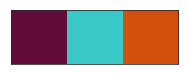

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#set font size of labels on matplotlib plots
plt.rc('font', size=16)

#set style of plots
sns.set_style('white')

#define a custom palette
customPalette = ['#630C3A', '#39C8C6', '#D3500C']
sns.set_palette(customPalette)
sns.palplot(customPalette)

NameError: name 'data' is not defined

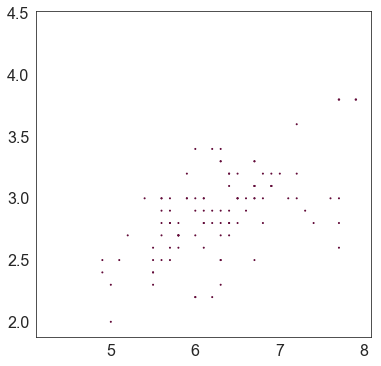

In [45]:
single_arr = make_arr_for_eval(expected_label, my_cluster_results[0])
plt.figure(figsize =(6, 6)) 
plt.scatter(iris_data['sepal_length'],iris_data['sepal_width'],single_arr, cmap ='rainbow')
facet = sns.lmplot(data=data, x='x', y='y', hue='label', 
                   fit_reg=False, legend=True, legend_out=True)